# Dynamic Nelson Siegel model implementation

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

In [2]:

df = pd.read_excel('NS_adatok_cln.xlsx')
rename_dict = {
    'DATE': 'Date',
    'M0.033': 'M0.033',
    'M1': 'M1',
    'M3': 'M3',
    'M6': 'M6',
    'M12': 'M12',
    'M36': 'M36',
    'M60': 'M60',
    'M120': 'M120',
    'M180': 'M180',
    'Kamat': 'Base_Rate',
    'Árfolyam': 'Exchange_Rate',
    'GDP': 'GDP',
    'Végső fogyasztás': 'Final_Consumption',
    'Export': 'Export',
    'Kockázati prémium': 'Risk_Premium',
    'Külső kamat': 'External_Interest_Rate',
    'Privát foglalkoztatott': 'Private_Employment',
    'Teljes állami létszám': 'Total_Public_Employment',
    'Közmunkások': 'Public_Work_Participants',
    'Állami létszám közfoglalkoztatottak nélkül': 'Public_Employment_Excl_Public_Work',
    'Infláció': 'Inflation',
    'Importár': 'Import_Price',
    'Háztartások rendelkezésre álló jövedelme': 'Household_Disposable_Income',
    'Háztartások rendelkezésre álló jövedelme (2015)': 'Household_Disposable_Income_2015',
    'Háztartások megtakarítása': 'Household_Savings'
}
df.rename(columns=rename_dict, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

yield_cols = ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180']
maturities = np.array([0.033, 1, 3, 6, 12, 36, 60, 120, 180]) / 12.0
lam_fixed = 0.7308

lambda_2f = 0.7308
lambda_3f = 0.7308

data_clean = df[yield_cols].copy()
data_clean['Base_Rate'] = df['Base_Rate']
data_clean['Inflation'] = df['Inflation']
data_clean['GDP_Growth'] = df['GDP'].pct_change() * 100
data_clean['FX_Change'] = df['Exchange_Rate'].pct_change() * 100
data_clean = data_clean.dropna()

scaler = StandardScaler()
macro_cols = ['Base_Rate', 'Inflation', 'GDP_Growth', 'FX_Change']
data_clean[macro_cols] = scaler.fit_transform(data_clean[macro_cols])

def get_ns_loadings(tau, lam, factors=3):
    if factors == 3:
        lam = lambda_3f
    if factors == 2:
        lam = lambda_2f
    l1 = np.ones_like(tau)
    l2 = (1 - np.exp(-lam * tau)) / (lam * tau)
    if factors == 3:
        l3 = l2 - np.exp(-lam * tau)
        return np.column_stack([l1, l2, l3])
    return np.column_stack([l1, l2])

class RobustDNS(MLEModel):
    def __init__(self, endog, maturities, n_ns_factors, lam=0.7308):
        k_states = n_ns_factors + 4
        super(RobustDNS, self).__init__(endog, k_states=k_states, k_posdef=k_states)
        self.n_ns = n_ns_factors
        self.n = k_states
        self.ssm['design', :len(maturities), :n_ns_factors] = get_ns_loadings(maturities, lam, n_ns_factors)
        self.ssm['design', len(maturities):, n_ns_factors:] = np.eye(4)
        self.ssm['selection'] = np.eye(k_states)
        self.initialize_approximate_diffuse()

    def update(self, params, **kwargs):
        params = super(RobustDNS, self).update(params, **kwargs)
        n = self.n
        idx = 0
        transition_flat = params[idx : idx + n**2]
        self.ssm['transition', :, :] = np.tanh(transition_flat).reshape(n, n)
        idx += n**2
        for i in range(n):
            self.ssm['state_cov', i, i] = np.exp(params[idx])
            idx += 1
        for i in range(self.k_endog):
            self.ssm['obs_cov', i, i] = np.exp(params[idx])
            idx += 1

    @property
    def start_params(self):
        n = self.n
        t_start = np.eye(n) * 0.8
        t_start_flat = t_start.flatten()
        q_start = [-2.0] * n
        r_start = [-3.0] * self.k_endog
        return np.concatenate([t_start_flat, q_start, r_start])

# OLS estimations
reg = LinearRegression(fit_intercept=False)
ols_3f_res, ols_2f_res = [], []
for i in range(len(data_clean)):
    y = data_clean[yield_cols].iloc[i].values
    ols_3f_res.append(reg.fit(get_ns_loadings(maturities, lambda_3f, 3), y).coef_)
    ols_2f_res.append(reg.fit(get_ns_loadings(maturities, lambda_2f, 2), y).coef_)

ols_3f = pd.DataFrame(ols_3f_res, index=data_clean.index, columns=['Level', 'Slope', 'Curvature'])
ols_2f = pd.DataFrame(ols_2f_res, index=data_clean.index, columns=['Level', 'Slope'])

# Run models
endog_data = data_clean[yield_cols + macro_cols]

# Fit 3F Kalman (VAR)
model3f = RobustDNS(endog_data, maturities, 3)
res3f = model3f.fit(disp=False, maxiter=200)
kf3_f = pd.DataFrame(res3f.smoothed_state[:3, :].T, index=data_clean.index, columns=['Level', 'Slope', 'Curvature'])

# Fit 2F Kalman (VAR)
model2f = RobustDNS(endog_data, maturities, 2)
res2f = model2f.fit(disp=False, maxiter=200)
kf2_f = pd.DataFrame(res2f.smoothed_state[:2, :].T, index=data_clean.index, columns=['Level', 'Slope'])

/home/bence/PycharmProjects/Project_lab/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/bence/PycharmProjects/Project_lab/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bence/PycharmProjects/Project_lab/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/bence/PycharmProjects/Project_lab/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'OLS 3F': np.float64(0.19179796405346092), 'OLS 2F': np.float64(0.3396735308864125), 'Kalman 3F (VAR)': np.float64(0.24000321808430267), 'Kalman 2F (VAR)': np.float64(0.3817838427032546)}


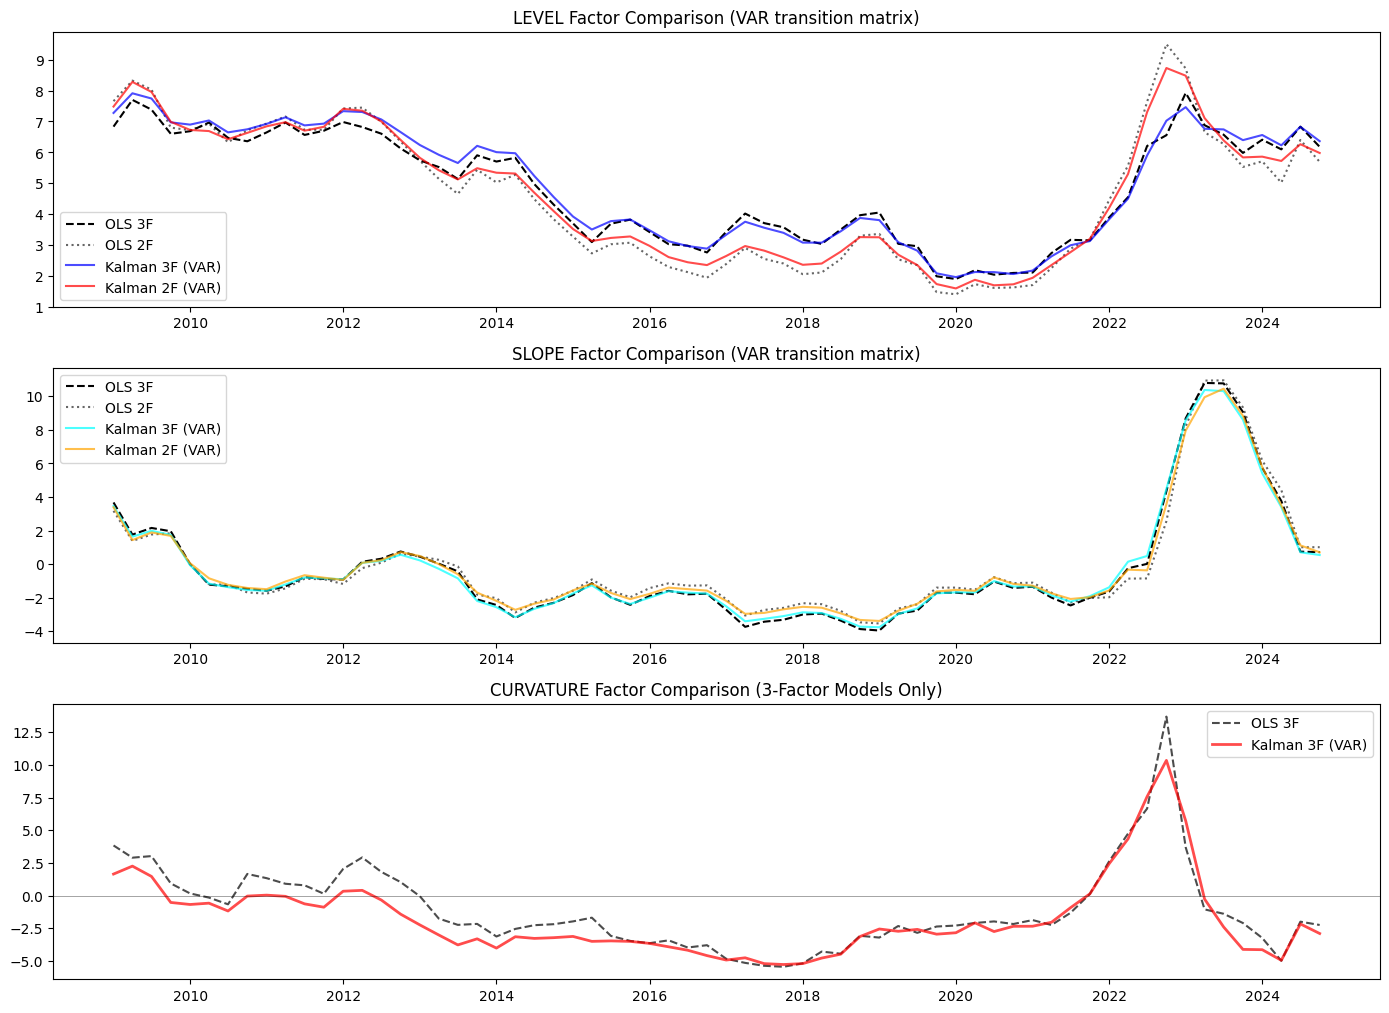

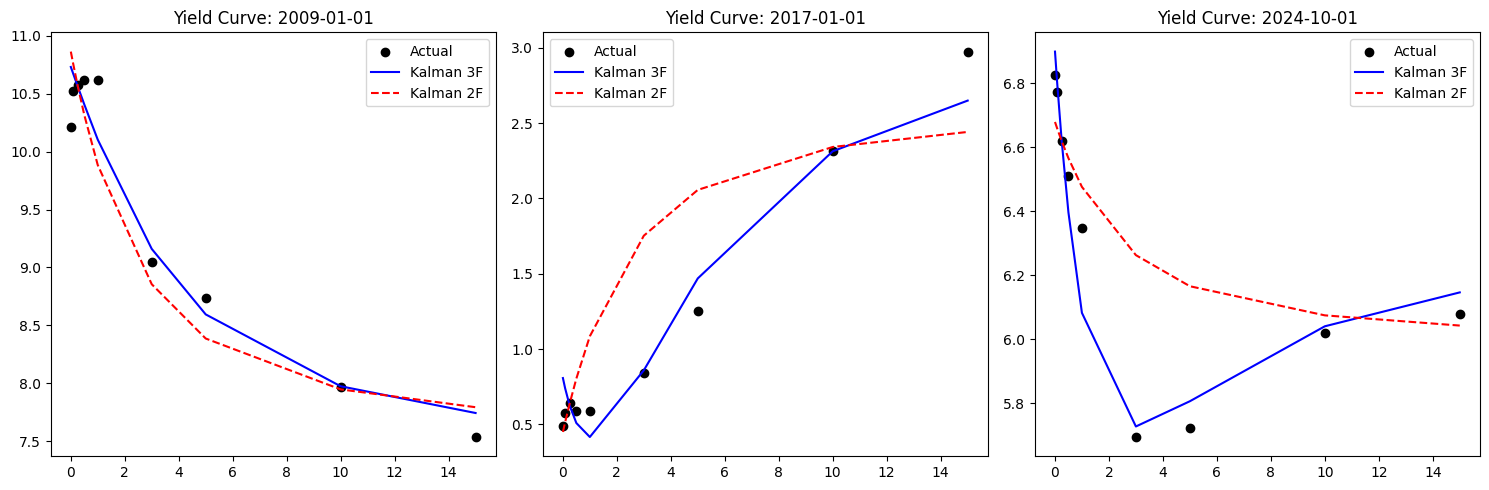

In [3]:
# RMSE Comparison
def get_rmse(obs, est, f):
    if f == 3:
        lam_fixed = lambda_3f
    if f == 2:
        lam_fixed = lambda_2f
    recon = est @ get_ns_loadings(maturities, lam_fixed, f).T
    return np.sqrt(((obs.values - recon.values)**2).mean())

rmse_stats = {
    "OLS 3F": get_rmse(data_clean[yield_cols], ols_3f, 3),
    "OLS 2F": get_rmse(data_clean[yield_cols], ols_2f, 2),
    "Kalman 3F (VAR)": get_rmse(data_clean[yield_cols], kf3_f, 3),
    "Kalman 2F (VAR)": get_rmse(data_clean[yield_cols], kf2_f, 2)
}

# Plot 1: Factor Comparison
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(ols_3f['Level'], label='OLS 3F', color='black', linestyle='--')
plt.plot(ols_2f['Level'], label='OLS 2F', color='black', linestyle='dotted', alpha=0.6)
plt.plot(kf3_f['Level'], label='Kalman 3F (VAR)', color='blue', alpha=0.7)
plt.plot(kf2_f['Level'], label='Kalman 2F (VAR)', color='red', alpha=0.7)
plt.title('LEVEL Factor Comparison (VAR transition matrix)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(ols_3f['Slope'], label='OLS 3F', color='black', linestyle='--')
plt.plot(ols_2f['Slope'], label='OLS 2F', color='black', linestyle='dotted', alpha=0.6)
plt.plot(kf3_f['Slope'], label='Kalman 3F (VAR)', color='cyan', alpha=0.7)
plt.plot(kf2_f['Slope'], label='Kalman 2F (VAR)', color='orange', alpha=0.7)
plt.title('SLOPE Factor Comparison (VAR transition matrix)')
plt.legend()
plt.tight_layout()
#plt.savefig('factor_comparison.png')

# 3. Grafikon: CURVATURE (Görbület)
# Megjegyzés: Csak a 3-faktoros modellek rendelkeznek görbülettel
plt.subplot(3, 1, 3)
plt.plot(ols_3f['Curvature'], label='OLS 3F', color='black', linestyle='--', alpha=0.7)
plt.plot(kf3_f['Curvature'], label='Kalman 3F (VAR)', color='red', alpha=0.7, linewidth=2)
plt.axhline(0, color='black', linewidth=0.5, alpha=0.5) # Nulla vonal a tájékozódáshoz
plt.title('CURVATURE Factor Comparison (3-Factor Models Only)')
plt.legend()

# Plot 2: Selected Curves
sample_idx = [0, len(data_clean)//2, -1]
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_idx):
    date = data_clean.index[idx]
    plt.subplot(1, 3, i+1)
    plt.scatter(maturities, data_clean.iloc[idx][yield_cols], color='black', label='Actual')

    # 3F Reconstruction
    recon3f = kf3_f.iloc[idx].values @ get_ns_loadings(maturities, lambda_3f, 3).T
    plt.plot(maturities, recon3f, label='Kalman 3F', color='blue')

    # 2F Reconstruction
    recon2f = kf2_f.iloc[idx].values @ get_ns_loadings(maturities, lambda_2f, 2).T
    plt.plot(maturities, recon2f, label='Kalman 2F', color='red', linestyle='--')

    plt.title(f'Yield Curve: {date.date()}')
    plt.legend()
plt.tight_layout()
plt.savefig('curve_fitting.png')

print(rmse_stats)

Cél dátum: 2024-07-01 | Felhasznált adat: 2024-07-01


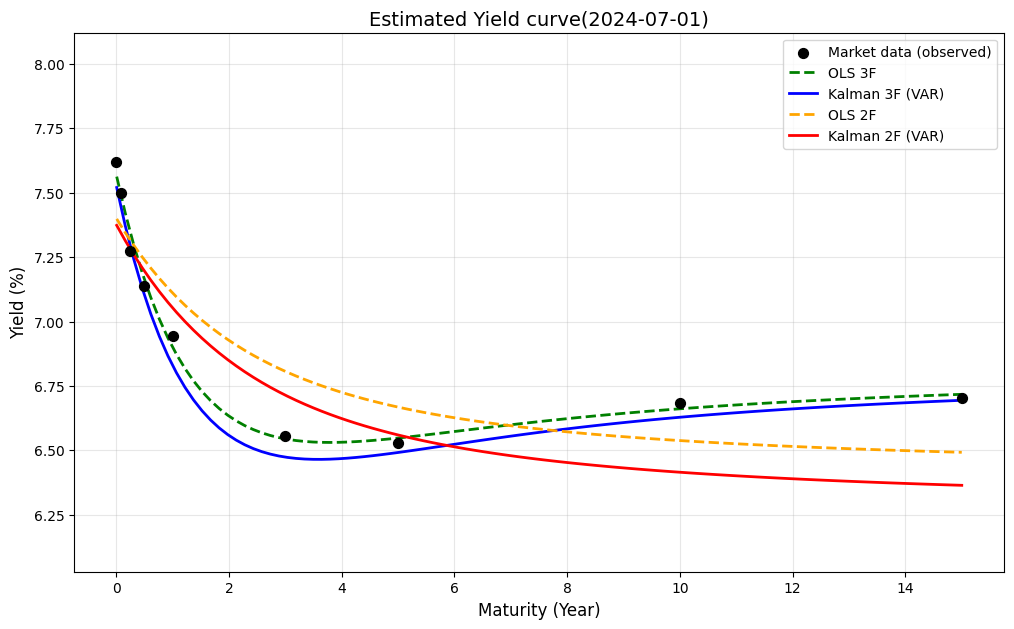

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_models_on_date(target_date_str, data_obs, maturities_obs, models_dict):
    """
    Kiplottolja a tényleges hozamokat és a 4 modell illesztését egy adott napra.
    models_dict: {'Modell neve': (faktor_df, n_factors)}
    """
    # 1. Dátum kezelése (legközelebbi elérhető index kiválasztása)
    target_date = pd.to_datetime(target_date_str)
    available_dates = data_obs.index
    actual_date = available_dates[np.argmin(np.abs(available_dates - target_date))]

    print(f"Cél dátum: {target_date_str} | Felhasznált adat: {actual_date.date()}")

    # 2. Sima görbe rajzolásához lejárati tartomány (0.1 - 15 év)
    maturities_smooth = np.linspace(0.01, 15, 100)

    plt.figure(figsize=(12, 7))

    # 3. Tényleges piaci adatok (fekete pontok)
    actual_yields = data_obs.loc[actual_date, yield_cols].values
    plt.scatter(maturities_obs, actual_yields, color='black', s=50, label='Market data (observed)', zorder=5)

    # 4. Modellek futtatása a kiválasztott napra
    colors = {'OLS 3F': 'green', 'Kalman 3F (VAR)': 'blue', 'OLS 2F': 'orange', 'Kalman 2F (VAR)': 'red'}
    linestyles = {'OLS 3F': '--', 'Kalman 3F (VAR)': '-', 'OLS 2F': '--', 'Kalman 2F (VAR)': '-'}

    for name, (factor_df, n_f, lam) in models_dict.items():
        # Faktorok kinyerése az adott napra
        factors = factor_df.loc[actual_date].values

        # Elméleti hozamok számítása a sima görbéhez
        L_smooth = get_ns_loadings(maturities_smooth, lam, n_f)
        fitted_curve = L_smooth @ factors

        plt.plot(maturities_smooth, fitted_curve,
                 label=name, color=colors[name],
                 linestyle=linestyles[name], linewidth=2)

    # 5. Formázás
    plt.title(f'Estimated Yield curve({actual_date.date()})', fontsize=14)
    plt.xlabel('Maturity (Year)', fontsize=12)
    plt.ylabel('Yield (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(min(actual_yields)-0.5, max(actual_yields)+0.5)
    plt.show()



# 1. Regisztráljuk a már korábban kiszámított modell-faktorokat
# Feltételezzük, hogy kf3_f, kf2_f, ols_3f, ols_2f változók léteznek a memóriában
all_models = {
    'OLS 3F': (ols_3f, 3, lambda_3f),
    'Kalman 3F (VAR)': (kf3_f, 3, lambda_3f),
    'OLS 2F': (ols_2f, 2, lambda_2f),
    'Kalman 2F (VAR)': (kf2_f, 2, lambda_2f)
}

# 2. Futtatás a kért dátumra
plot_models_on_date('2024-07-01', data_clean, maturities, all_models)

In [5]:
# --- PARAMÉTEREK ÉS STABILITÁS ELLENŐRZÉSE ---

def analyze_stability(results, name):
    # 1. Átmeneti mátrix (T) kinyerése
    T = results.model.ssm['transition', :, :, 0]

    # 2. Sajátértékek vizsgálata (Stabilitás feltétele: minden sajátérték < 1)
    eigenvalues = np.linalg.eigvals(T)
    max_eig = np.abs(eigenvalues).max()

    # 3. Varianciák (Q: folyamatzaj, R: mérési zaj)
    # Átlagos mérési hiba (R mátrix főátlója)
    avg_obs_error = np.sqrt(np.diag(results.model.ssm['obs_cov', :, :, 0])).mean()
    # Átlagos állapot-bizonytalanság (Q mátrix főátlója)
    avg_state_innov = np.sqrt(np.diag(results.model.ssm['state_cov', :, :, 0])).mean()

    print(f"\n--- {name} Elemzése ---")
    print(f"Max sajátérték (Stabilitás < 1): {max_eig:.4f}")
    print(f"Átlagos mérési bizonytalanság (R): {avg_obs_error:.4f}%")
    print(f"Átlagos faktor-ingadozás (Q): {avg_state_innov:.4f}")
    print(f"AIC érték (Kisebb a jobb): {results.aic:.2f}")


analyze_stability(res3f, "Kalman 3-Faktor (VAR)")
analyze_stability(res2f, "Kalman 2-Faktor (VAR)")


--- Kalman 3-Faktor (VAR) Elemzése ---
Max sajátérték (Stabilitás < 1): 0.9917
Átlagos mérési bizonytalanság (R): 0.2614%
Átlagos faktor-ingadozás (Q): 0.4660
AIC érték (Kisebb a jobb): 630.37

--- Kalman 2-Faktor (VAR) Elemzése ---
Max sajátérték (Stabilitás < 1): 0.9925
Átlagos mérési bizonytalanság (R): 0.3429%
Átlagos faktor-ingadozás (Q): 0.3667
AIC érték (Kisebb a jobb): 1009.66


Átlagos RMSE - OLS 3F:    0.1834%
Átlagos RMSE - Kalman 3F: 0.1881%
Átlagos RMSE - OLS 2F:    0.3199%
Átlagos RMSE - Kalman 2F: 0.3277%


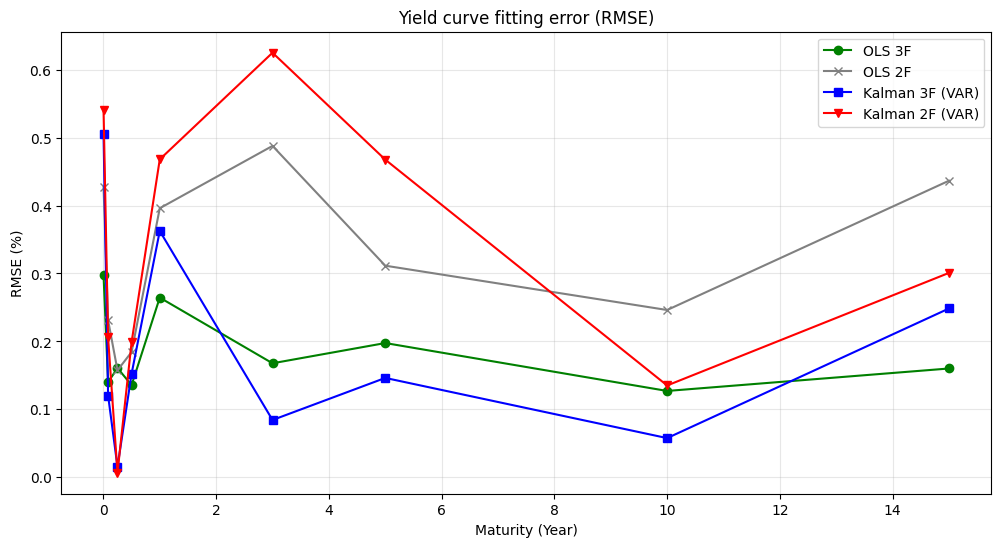

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# --- REZIDUÁLIS ELEMZÉS FUNKCIÓ ---
def analyze_residuals_all(observed_yields, estimated_factors, maturities, lam, n_factors):
    # Nelson-Siegel loading mátrix (Z) generálása
    L = get_ns_loadings(maturities, lam, n_factors)

    # Hozamok rekonstruálása: Y = Faktorok @ L.T
    reconstructed = estimated_factors.values @ L.T
    reconstructed_df = pd.DataFrame(reconstructed, index=observed_yields.index, columns=observed_yields.columns)

    # Hibák (Reziduálisok) = Megfigyelt - Rekonstruált
    residuals = observed_yields - reconstructed_df

    # RMSE (Root Mean Square Error) kiszámítása lejáratonként
    rmse_per_maturity = np.sqrt((residuals**2).mean())
    return rmse_per_maturity

# --- SZÁMÍTÁSOK ---
rmse_ols3 = analyze_residuals_all(data_clean[yield_cols], ols_3f, maturities, lambda_3f, 3)
rmse_kf3  = analyze_residuals_all(data_clean[yield_cols], kf3_f, maturities, lambda_3f, 3)
rmse_ols2 = analyze_residuals_all(data_clean[yield_cols], ols_2f, maturities, lambda_2f, 2)
rmse_kf2  = analyze_residuals_all(data_clean[yield_cols], kf2_f, maturities, lambda_2f, 2)

# Összegzés megjelenítése
print(f"Átlagos RMSE - OLS 3F:    {rmse_ols3.mean():.4f}%")
print(f"Átlagos RMSE - Kalman 3F: {rmse_kf3.mean():.4f}%")
print(f"Átlagos RMSE - OLS 2F:    {rmse_ols2.mean():.4f}%")
print(f"Átlagos RMSE - Kalman 2F: {rmse_kf2.mean():.4f}%")

# Vizualizáció (Lejáratonkénti hiba)
plt.figure(figsize=(12, 6))
plt.plot(maturities, rmse_ols3, label='OLS 3F', marker='o', color='green')
plt.plot(maturities, rmse_ols2, label='OLS 2F', marker='x', color='grey')
plt.plot(maturities, rmse_kf3, label='Kalman 3F (VAR)', marker='s', color='blue')
plt.plot(maturities, rmse_kf2, label='Kalman 2F (VAR)', marker='v', color='red')
plt.title('Yield curve fitting error (RMSE)')
plt.xlabel('Maturity (Year)')
plt.ylabel('RMSE (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

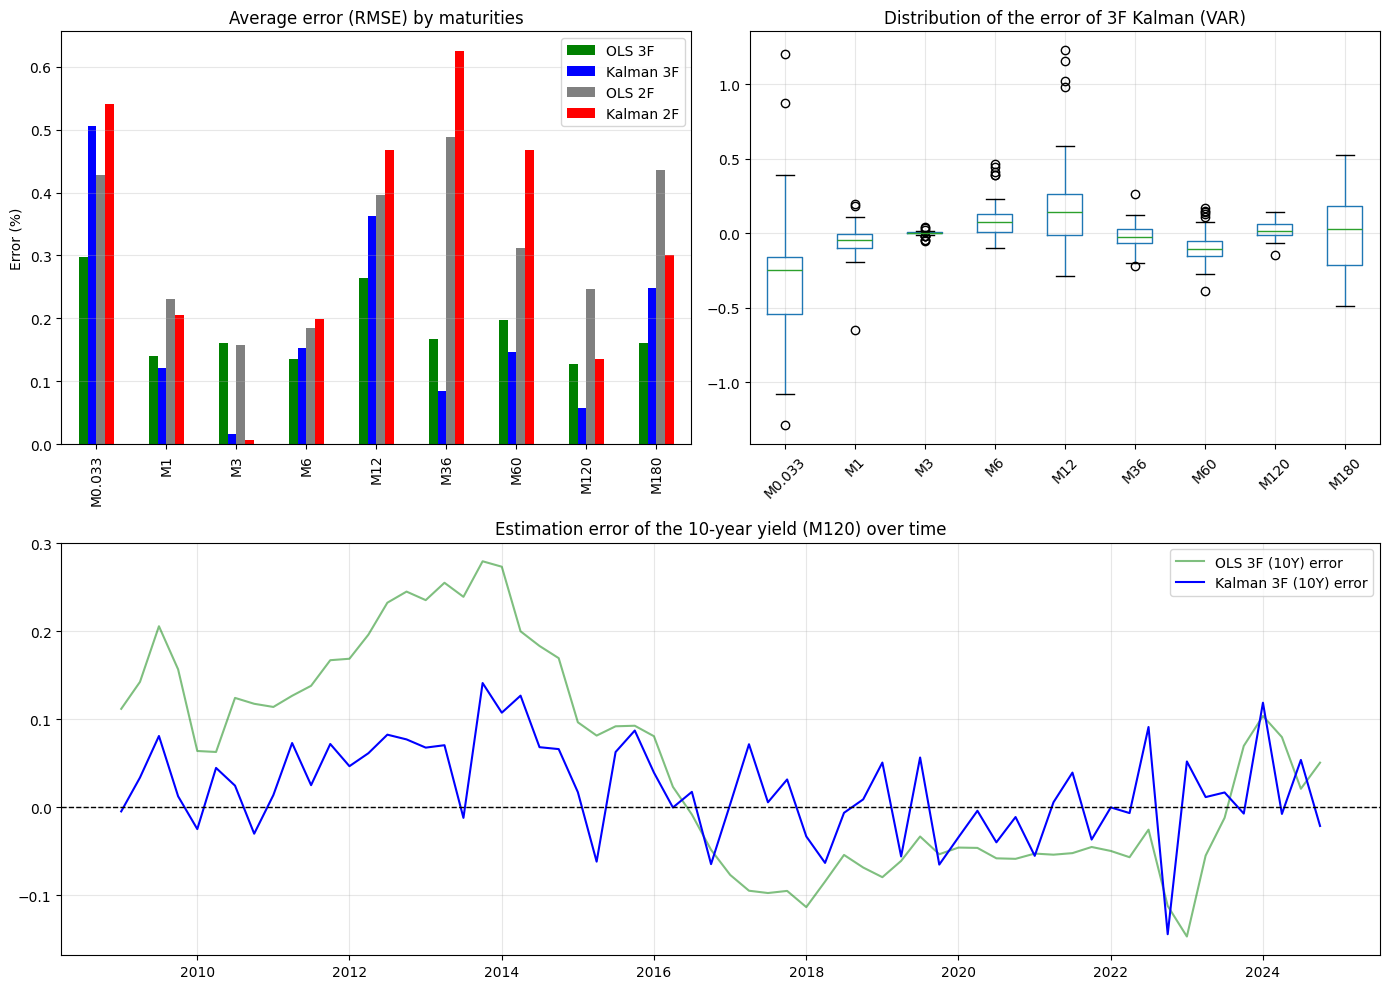


--- Full average RMSE ---
OLS 3F       0.183404
Kalman 3F    0.188084
OLS 2F       0.319903
Kalman 2F    0.327680
dtype: float64


In [7]:
def get_res_and_rmse(obs, est, n_factors):
    if n_factors == 3:
        lam_fixed = lambda_3f
    if n_factors == 2:
        lam_fixed = lambda_2f
    L = get_ns_loadings(maturities, lam_fixed, n_factors)
    recon = pd.DataFrame(est.values @ L.T, index=obs.index, columns=obs.columns)
    residuals = obs - recon
    rmse = np.sqrt((residuals**2).mean())
    return residuals, rmse

res_kf3, rmse_kf3 = get_res_and_rmse(data_clean[yield_cols], kf3_f, 3)
res_kf2, rmse_kf2 = get_res_and_rmse(data_clean[yield_cols], kf2_f, 2)
res_ols3, rmse_ols3 = get_res_and_rmse(data_clean[yield_cols], ols_3f, 3)
res_ols2, rmse_ols2 = get_res_and_rmse(data_clean[yield_cols], ols_2f, 2)
rmse_comparison = pd.DataFrame({
    'OLS 3F': rmse_ols3,
    'Kalman 3F': rmse_kf3,
    'OLS 2F': rmse_ols2,
    'Kalman 2F': rmse_kf2
})

# --- 5. SPECIÁLIS VIZUALIZÁCIÓ ---
plt.figure(figsize=(14, 10))

# 1. Grafikon: Átlagos hiba lejáratonként (Bar chart)
plt.subplot(2, 2, 1)
rmse_comparison.plot(kind='bar', ax=plt.gca(), color=['green', 'blue', 'grey', 'red'])
plt.title('Average error (RMSE) by maturities')
plt.ylabel('Error (%)')
plt.grid(axis='y', alpha=0.3)

# 2. Grafikon: Reziduálisok eloszlása (Boxplot)
plt.subplot(2, 2, 2)
res_kf3.boxplot(ax=plt.gca())
plt.title('Distribution of the error of 3F Kalman (VAR)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# 3. Grafikon: Hiba időbeli alakulása (10 év - M120)
plt.subplot(2, 1, 2)
plt.plot(res_ols3['M120'], label='OLS 3F (10Y) error', alpha=0.5, color='green')
plt.plot(res_kf3['M120'], label='Kalman 3F (10Y) error', color='blue', linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Estimation error of the 10-year yield (M120) over time')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Összesített statisztika kiírása
print("\n--- Full average RMSE ---")
print(rmse_comparison.mean())

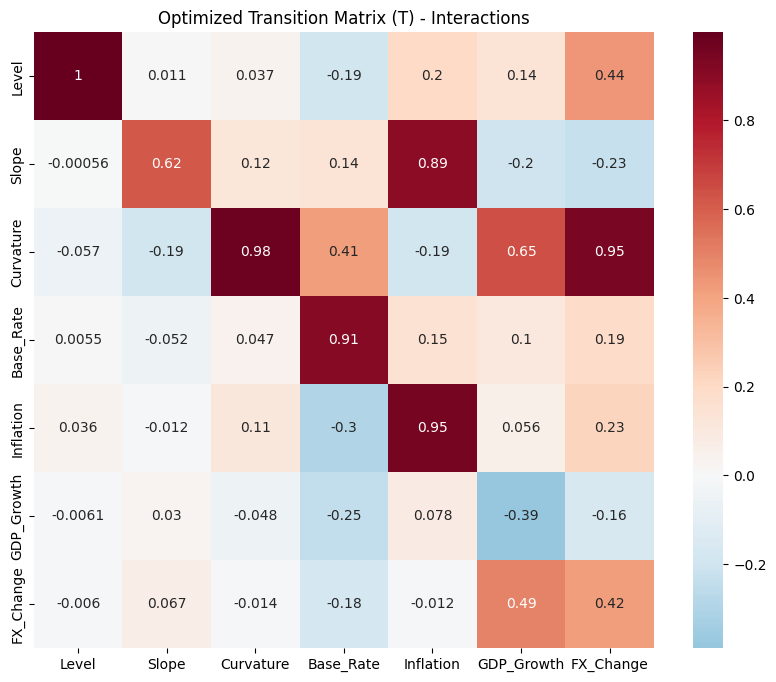

In [8]:
# --- 1. PARAMÉTEREK ÉS ÁTMENETI MÁTRIX KINYERÉSE ---
# Közvetlenül a modell ssm (state space model) objektumából
T_matrix = res3f.model.ssm['transition', :, :, 0]
state_names = ['Level', 'Slope', 'Curvature', 'Base_Rate', 'Inflation', 'GDP_Growth', 'FX_Change']

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(T_matrix, annot=True, xticklabels=state_names, yticklabels=state_names, cmap='RdBu_r', center=0)
plt.title("Optimized Transition Matrix (T) - Interactions")
plt.show()

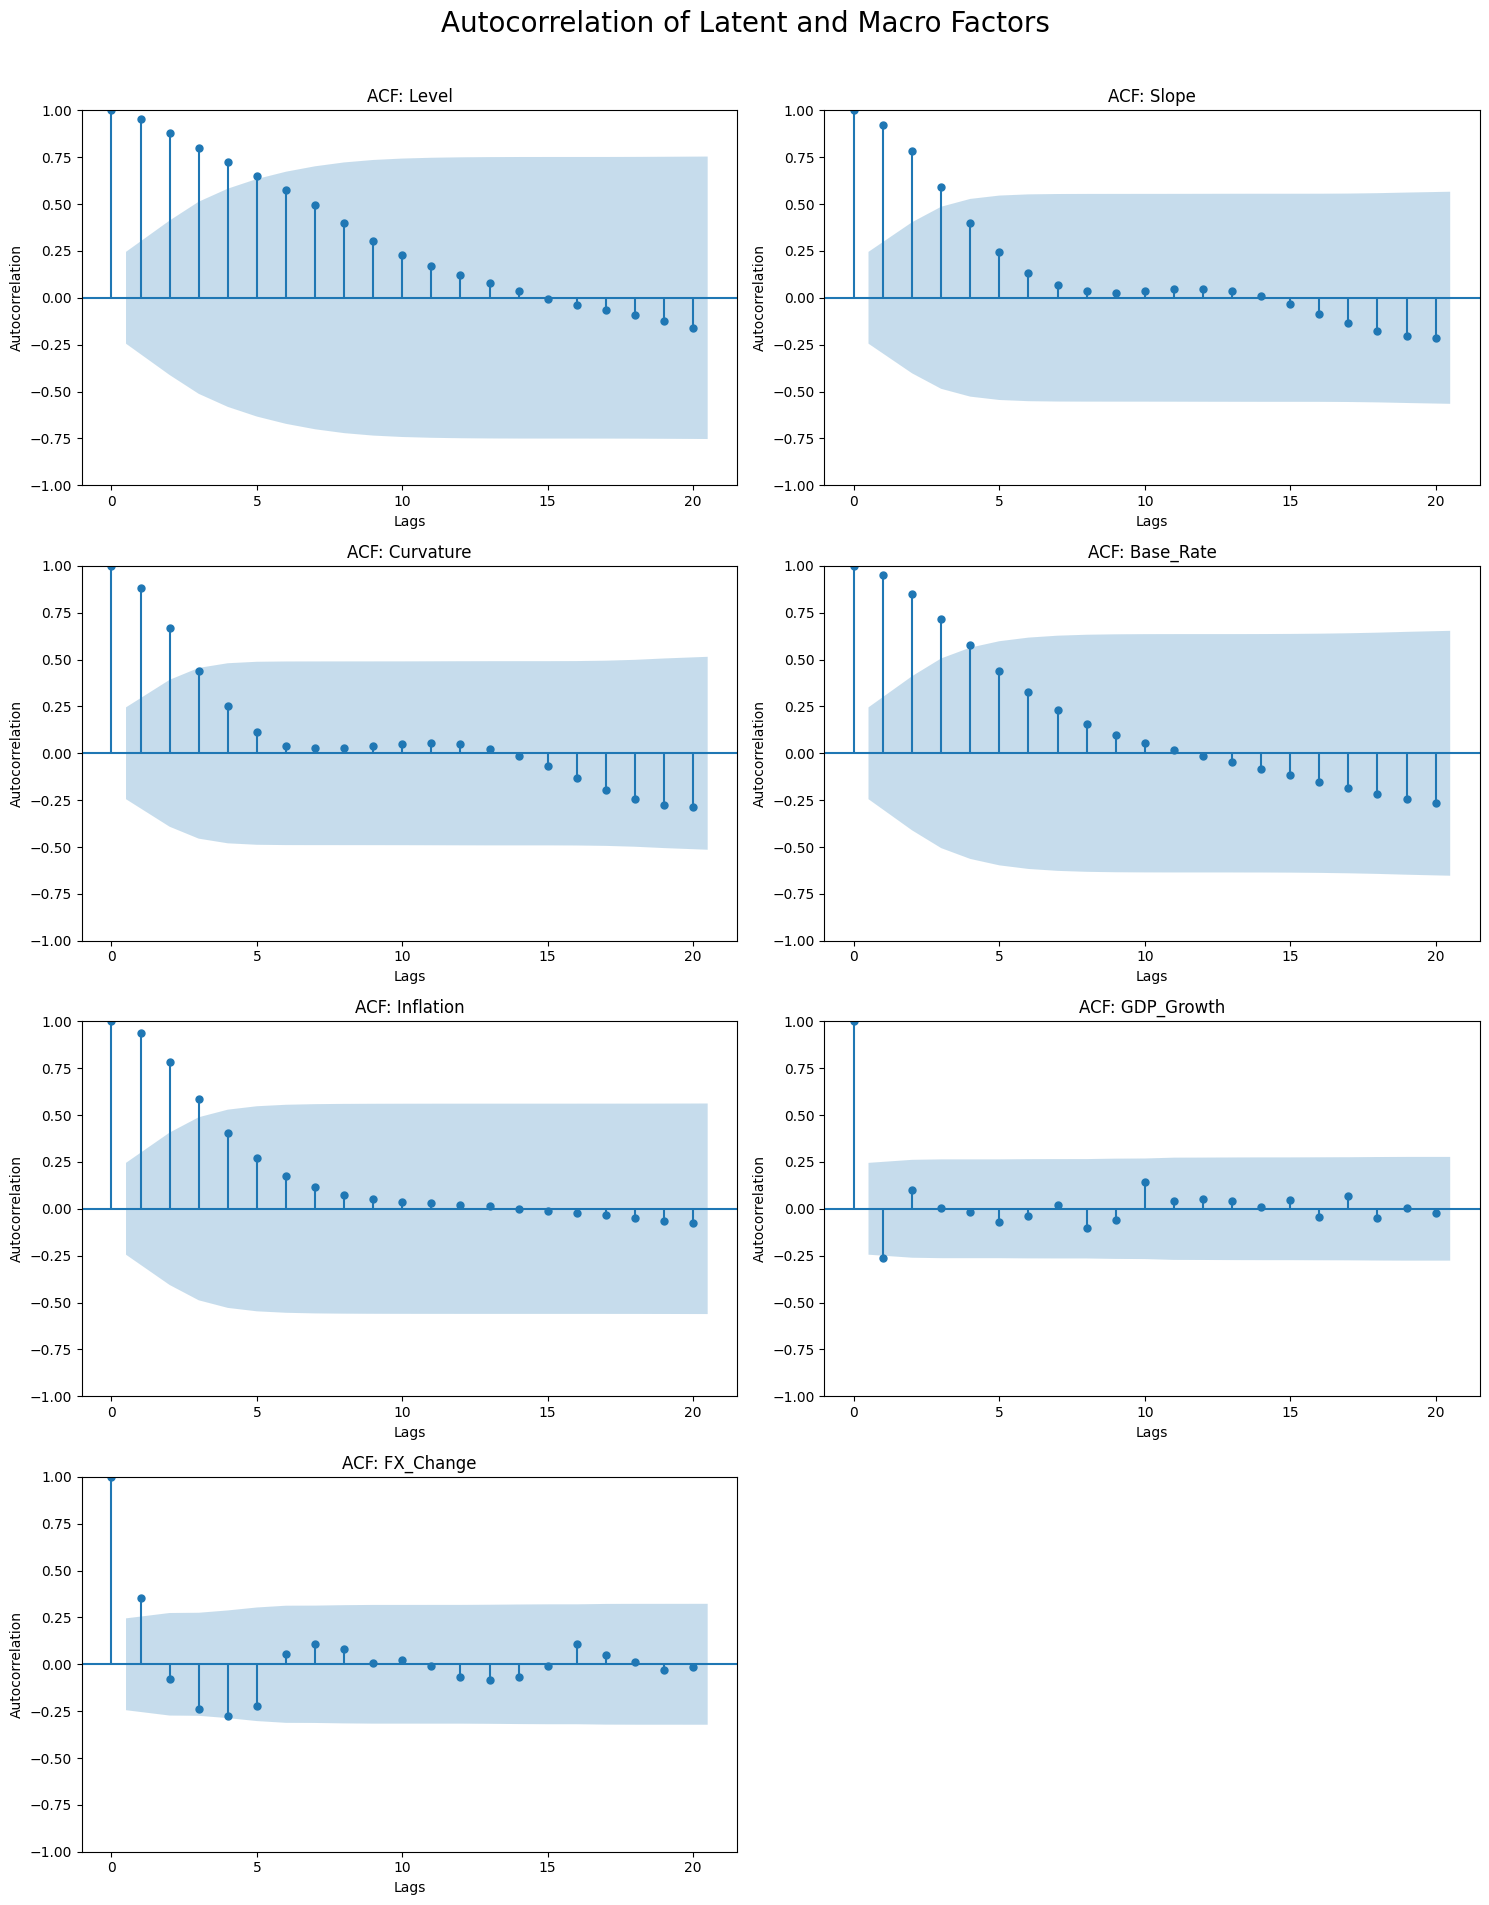

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf  # <--- Direct import fixed here

# 1. Extract all factors from the smoothed state
# (Assuming 'res3f' and 'data_clean' are already defined in your notebook)
state_names = ['Level', 'Slope', 'Curvature', 'Base_Rate', 'Inflation', 'GDP_Growth', 'FX_Change']
all_factors = pd.DataFrame(res3f.smoothed_state.T, index=data_clean.index, columns=state_names)

# 2. Setup the plot grid (4 rows, 2 columns for 7 factors)
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Autocorrelation of Latent and Macro Factors', fontsize=20)

axes = axes.flatten()

# 3. Loop through factors and plot ACF
for i, col in enumerate(state_names):
    # Using the directly imported plot_acf function
    plot_acf(all_factors[col], ax=axes[i], lags=20, title=f'ACF: {col}')
    axes[i].set_xlabel('Lags')
    axes[i].set_ylabel('Autocorrelation')

# Remove the empty 8th subplot
fig.delaxes(axes[7])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [10]:
# Fit 3F Kalman (VAR)
endog_data = data_clean[yield_cols + macro_cols]
model3f = RobustDNS(endog_data, maturities, 3)
res3f = model3f.fit(disp=False, maxiter=300)

# Extract Transition Matrix
T_matrix_raw = res3f.model.ssm['transition', :, :, 0]
state_names = ['Level', 'Slope', 'Curvature', 'Base_Rate', 'Inflation', 'GDP_Growth', 'FX_Change']
T_df = pd.DataFrame(T_matrix_raw, index=state_names, columns=state_names)

# Extract diagonal of Q (state variances)
Q_diag = np.diag(res3f.model.ssm['state_cov', :, :, 0])
Q_df = pd.DataFrame(Q_diag, index=state_names, columns=['State_Variance'])

# Extract diagonal of R (observation variances) - average over yields
R_diag = np.diag(res3f.model.ssm['obs_cov', :, :, 0])
R_yields_avg = np.sqrt(R_diag[:len(yield_cols)]).mean()
R_macro_avg = np.sqrt(R_diag[len(yield_cols):]).mean()

# Cross-effects: Macro -> Yield Factors
cross_effects = T_df.loc[['Level', 'Slope', 'Curvature'], ['Base_Rate', 'Inflation', 'GDP_Growth', 'FX_Change']]

print("Transition Matrix:\n", T_df)
print("\nCross Effects (Macro -> Factors):\n", cross_effects)
print("\nState Variances (Q):\n", Q_df)
print("\nAverage Observation RMSE Yields (R):", R_yields_avg)
cross_effects.to_csv('macro_factor_relations.csv')

/home/bence/PycharmProjects/Project_lab/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/bence/PycharmProjects/Project_lab/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Transition Matrix:
                Level     Slope  Curvature  Base_Rate  Inflation  GDP_Growth  \
Level       0.999271  0.011001   0.037609  -0.192762   0.199358    0.137643   
Slope      -0.002147  0.621088   0.121420   0.136561   0.890634   -0.204091   
Curvature  -0.056815 -0.194256   0.975449   0.414207  -0.193019    0.645027   
Base_Rate   0.005511 -0.052680   0.047069   0.905307   0.150089    0.103677   
Inflation   0.035533 -0.011758   0.114111  -0.298904   0.954366    0.055797   
GDP_Growth -0.005502  0.029557  -0.048059  -0.247404   0.077641   -0.390383   
FX_Change  -0.005761  0.067367  -0.013426  -0.180003  -0.012572    0.492057   

            FX_Change  
Level        0.436285  
Slope       -0.231133  
Curvature    0.946858  
Base_Rate    0.189382  
Inflation    0.227041  
GDP_Growth  -0.163283  
FX_Change    0.416598  

Cross Effects (Macro -> Factors):
            Base_Rate  Inflation  GDP_Growth  FX_Change
Level      -0.192762   0.199358    0.137643   0.436285
Slope    

Szimuláció indítása... Cél: 5000 sikeres minta / sokk típus
Próbálkozások: 1000 | Gyűjtött minták: [8, 5, 1449, 1802]
Próbálkozások: 2000 | Gyűjtött minták: [11, 14, 2902, 3556]
Próbálkozások: 3000 | Gyűjtött minták: [16, 18, 4385, 5000]
Próbálkozások: 4000 | Gyűjtött minták: [19, 18, 5000, 5000]
Próbálkozások: 5000 | Gyűjtött minták: [23, 19, 5000, 5000]
Próbálkozások: 6000 | Gyűjtött minták: [29, 20, 5000, 5000]
Próbálkozások: 7000 | Gyűjtött minták: [33, 22, 5000, 5000]
Próbálkozások: 8000 | Gyűjtött minták: [38, 28, 5000, 5000]
Próbálkozások: 9000 | Gyűjtött minták: [41, 29, 5000, 5000]
Próbálkozások: 10000 | Gyűjtött minták: [46, 33, 5000, 5000]
Próbálkozások: 11000 | Gyűjtött minták: [54, 39, 5000, 5000]
Próbálkozások: 12000 | Gyűjtött minták: [61, 45, 5000, 5000]
Próbálkozások: 13000 | Gyűjtött minták: [65, 47, 5000, 5000]
Próbálkozások: 14000 | Gyűjtött minták: [67, 49, 5000, 5000]
Próbálkozások: 15000 | Gyűjtött minták: [74, 52, 5000, 5000]
Próbálkozások: 16000 | Gyűjtött mint

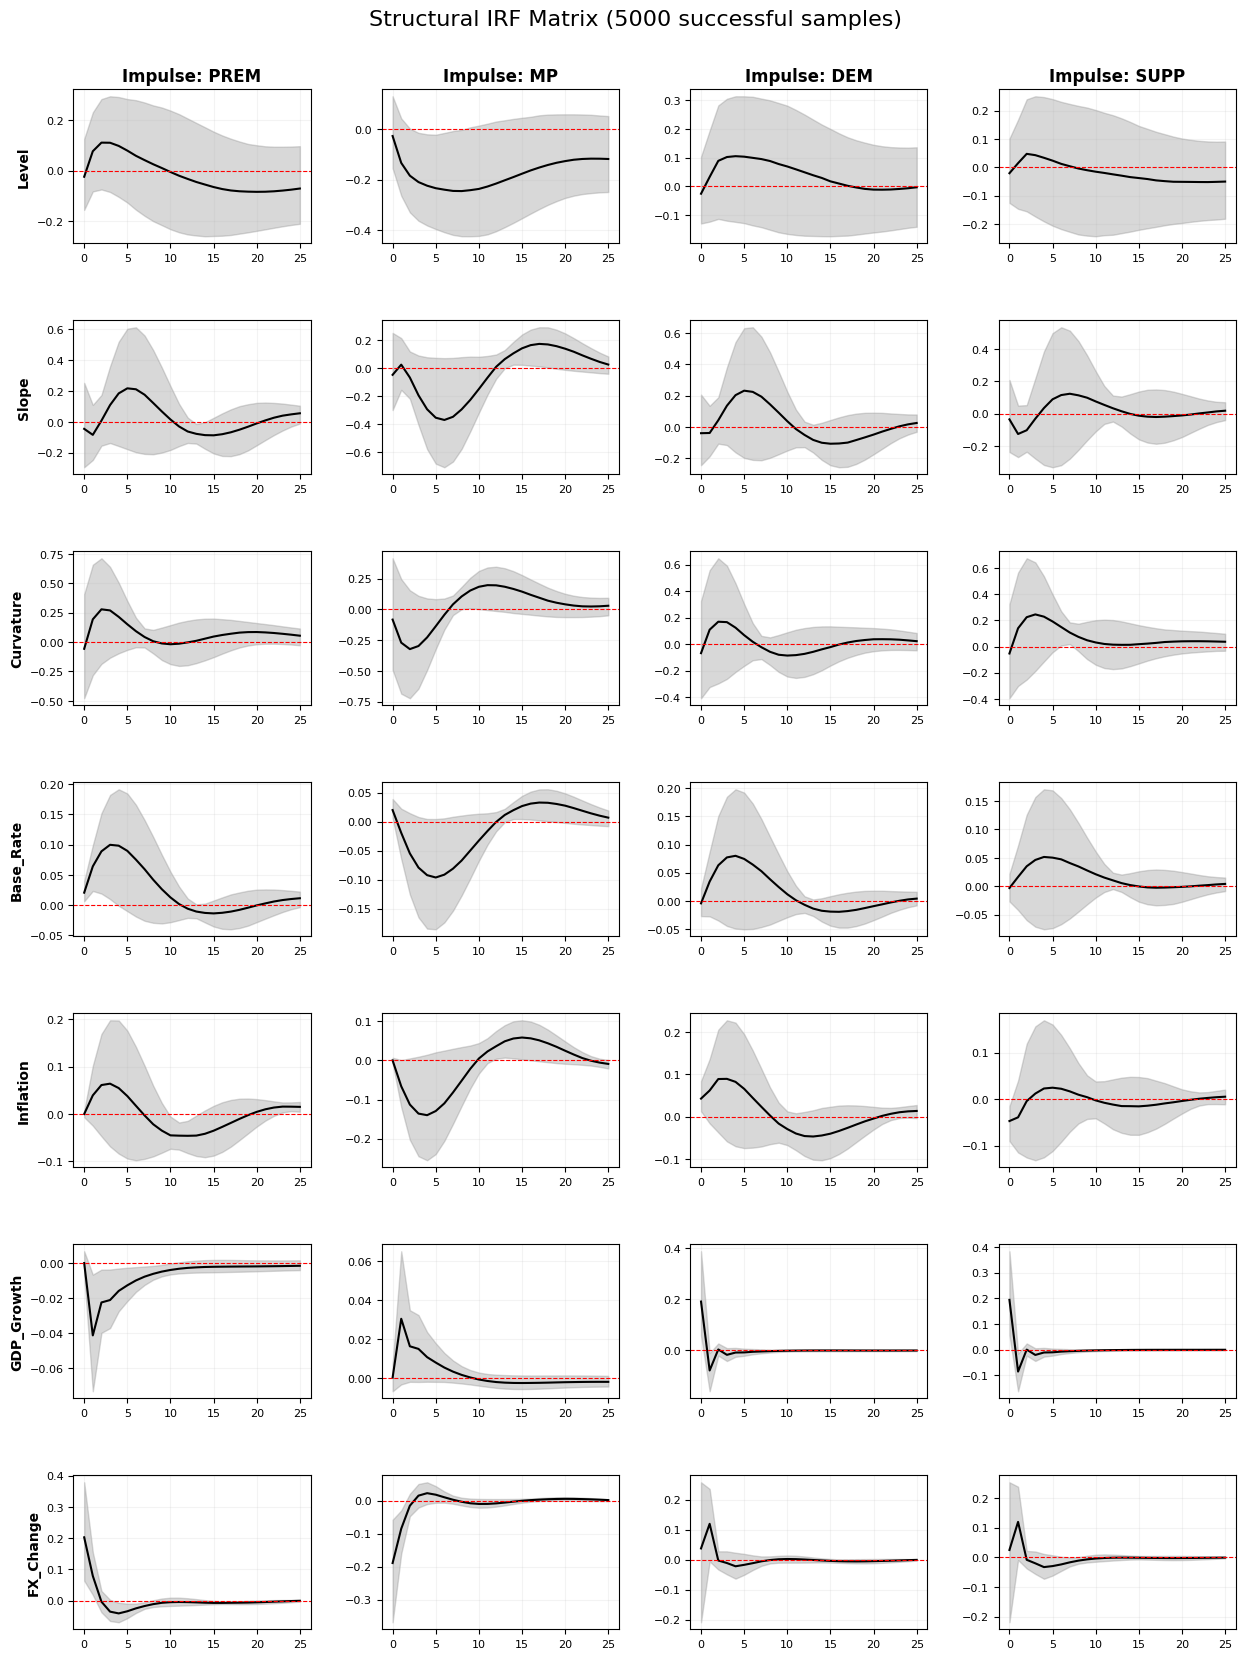

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.linalg import qr, cholesky

warnings.filterwarnings("ignore")

# ==========================================
# KONFIGURÁCIÓS PARAMÉTEREK
# ==========================================
N_SUCCESSFUL_SAMPLES = 5000
IRF_STEPS = 25               # number of quarters
CONFIDENCE_INTERVAL = [16, 84] # 1 std
res = res3f

# --- 1. REPPA-FÉLE ELŐJEL-MEGKÖTÉSEK (Table 6) ---
def check_reppa_signs_old(S_column, shock_type):
    # Állapotvektor indexek: 3:Base_Rate, 4:Inflation, 5:GDP_Growth, 6:FX_Change
    if shock_type == 'PREM':
        # Kockázati prémium: Kamat emelkedik (+), Forint gyengül (FX_Change > 0)
        return S_column[3] > 0 and S_column[6] > 0
    elif shock_type == 'MP':
        # Monetáris politika: Kamat emelkedik (+), Forint erősödik (FX_Change < 0)
        return S_column[3] > 0 and S_column[6] < 0
    elif shock_type == 'DEM':
        # Keresleti sokk: Infláció nő (+), GDP nő (+)
        return S_column[4] > 0 and S_column[5] > 0
    elif shock_type == 'SUPP':
        # Kínálati sokk: Infláció csökken (-), GDP nő (+)
        return S_column[4] < 0 and S_column[5] > 0
    return False

def check_reppa_signs(S_column, shock_type, tol=1e-2):
    # S_column indices: 3:Base_Rate, 4:Inflation, 5:GDP_Growth, 6:FX_Change

    if shock_type == 'PREM':
        # Kamat +, FX gyengül (+), Inf=0, GDP=0
        return (S_column[3] > 0 and S_column[6] > 0 and
                abs(S_column[4]) < tol and abs(S_column[5]) < tol)

    elif shock_type == 'MP':
        # Kamat +, FX erősödik (-), Inf=0, GDP=0
        return (S_column[3] > 0 and S_column[6] < 0 and
                abs(S_column[4]) < tol and abs(S_column[5]) < tol)

    elif shock_type == 'DEM':
        # Keresleti: Inf +, GDP +
        return S_column[4] > 0 and S_column[5] > 0

    elif shock_type == 'SUPP':
        # Kínálati: Inf -, GDP +
        return S_column[4] < 0 and S_column[5] > 0

    return False

# --- 2. STRUKTURÁLIS IRF GENERÁLÁSA ---
def run_structural_simulation(results, target_n, steps):
    state_names = ['Level', 'Slope', 'Curvature', 'Base_Rate', 'Inflation', 'GDP_Growth', 'FX_Change']
    shocks = ['PREM', 'MP', 'DEM', 'SUPP']

    T = results.model.ssm['transition', :, :, 0]
    Q = results.model.ssm['state_cov', :, :, 0]
    P = cholesky(Q, lower=True) # Zérus megkötések biztosítása (Cholesky)

    storage = {s: [] for s in shocks}
    print(f"Szimuláció indítása... Cél: {target_n} sikeres minta / sokk típus")

    attempts = 0
    while any(len(v) < target_n for v in storage.values()):
        attempts += 1
        # Véletlen ortogonális rotáció (Haar-measure)
        X = np.random.randn(7, 7)
        O, _ = qr(X)
        S = P @ O

        for i in range(7):
            candidate_col = S[:, i]
            for s_name in shocks:
                if len(storage[s_name]) < target_n:
                    if check_reppa_signs(candidate_col, s_name):
                        # Pálya kiszámítása
                        path = []
                        curr = candidate_col
                        for _ in range(steps + 1):
                            path.append(curr)
                            curr = T @ curr
                        storage[s_name].append(np.array(path))

        if attempts % 1000 == 0:
            progress = [len(v) for v in storage.values()]
            print(f"Próbálkozások: {attempts} | Gyűjtött minták: {progress}")

    # Statisztikák (Medián és Konfidencia sávok)
    final_output = {}
    for s_name in shocks:
        data = np.array(storage[s_name])
        final_output[s_name] = {
            'median': np.median(data, axis=0),
            'low': np.percentile(data, CONFIDENCE_INTERVAL[0], axis=0),
            'high': np.percentile(data, CONFIDENCE_INTERVAL[1], axis=0)
        }
    return final_output

# --- 3. MEGJELENÍTÉS (7x4 MÁTRIX) ---
irf_results = run_structural_simulation(res, N_SUCCESSFUL_SAMPLES, IRF_STEPS)
shock_list = ['PREM', 'MP', 'DEM', 'SUPP']
var_list = ['Level', 'Slope', 'Curvature', 'Base_Rate', 'Inflation', 'GDP_Growth', 'FX_Change']

fig, axes = plt.subplots(7, 4, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for c_idx, s_name in enumerate(shock_list):
    data = irf_results[s_name]
    for r_idx, v_name in enumerate(var_list):
        ax = axes[r_idx, c_idx]
        v_idx = var_list.index(v_name)

        # Konfidencia sáv
        ax.fill_between(range(IRF_STEPS + 1), data['low'][:, v_idx], data['high'][:, v_idx],
                        color='gray', alpha=0.3, label=f'{CONFIDENCE_INTERVAL[0]}-{CONFIDENCE_INTERVAL[1]}%')
        # Strukturális Medián IRF
        ax.plot(data['median'][:, v_idx], color='black', linewidth=1.5)
        ax.axhline(0, color='red', linestyle='--', linewidth=0.8)

        if r_idx == 0: ax.set_title(f"Impulse: {s_name}", fontweight='bold', fontsize=12)
        if c_idx == 0: ax.set_ylabel(v_name, fontweight='bold', fontsize=10)
        ax.grid(True, alpha=0.15)
        ax.tick_params(labelsize=8)

plt.suptitle(f"Structural IRF Matrix ({N_SUCCESSFUL_SAMPLES} successful samples)", fontsize=16, y=0.92)
plt.show()
